In [1]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, UpSampling2D, Input,Dropout,Conv2DTranspose,Concatenate
from keras.layers import  Conv1D, MaxPooling1D, UpSampling1D,Concatenate, PReLU
from keras import optimizers

Using TensorFlow backend.


In [2]:
original_dataset_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\recordings\\"

base_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\super_resolution_re_im"
train_dir = os.path.join(base_dir, 'train\\')

test_dir = os.path.join(base_dir, 'test\\')
train_dir_filtré=os.path.join(base_dir, 'train_dir_filtré\\')
test_dir_filtré=os.path.join(base_dir, 'test_dir_filtré\\')

In [3]:
Xtest,max_test= dir_to_wav_array(test_dir)
Xtrain,max_train= dir_to_wav_array(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [4]:
fce=0.02267#sr=22050
ftype="butter"
ordre=2
b,a = creer_filter(fce,"highpass",ftype,ordre)
filter_path(train_dir,train_dir_filtré,b,a)
filter_path(test_dir,test_dir_filtré,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [5]:
print(Xtest.shape)

(200, 8000, 1, 1)


In [6]:
Xtrain_fil,max_train_fil=dir_to_wav_array(train_dir_filtré)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [31]:
#réseau audio net
input_img = Input(shape=(8000,1,1))

conv1= Conv2D(32, (7, 1), padding='same',strides=1)(input_img)
conv1 = PReLU(shared_axes=[1, 2], name='prelu1')(conv1)
max1= MaxPooling2D((2, 1), padding='same')(conv1)

conv3 = Conv2D(32, (7, 1), padding='same',strides=1)(max1)
conv3 = PReLU(shared_axes=[1, 2], name='prelu3')(conv3)              
encoded = MaxPooling2D((2, 1), padding='same')(conv3)
x = Conv2D(32, (7, 1), padding='same',strides=1)(encoded)
x = PReLU(shared_axes=[1, 2], name='prelu4')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu5')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu6')(x)

x = UpSampling2D((2, 1))(x)
# merge2=Concatenate(axis=-1)([x,conv3])
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu8')(x)
# x=Dropout(0.5)(x)
x = UpSampling2D((2, 1))(x)
# merge1=Concatenate(axis=-1)([x,conv1])
decoded = Conv2D(1, (7, 1), padding='same',strides=1)(x)
decoded = PReLU(shared_axes=[1, 2], name='prelu9')(decoded)
# decoded=Dropout(0.5)(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8000, 1, 1)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8000, 1, 32)       256       
_________________________________________________________________
prelu1 (PReLU)               (None, 8000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4000, 1, 32)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4000, 1, 32)       7200      
_________________________________________________________________
prelu3 (PReLU)               (None, 4000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2000, 1, 32)       0         
__________

In [32]:
G=1
history=autoencoder.fit(Xtrain_fil*G,Xtrain*G,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil*G, Xtest*G))

Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0517 - val_loss: 0.0427
Epoch 2/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0373 - val_loss: 0.0288
Epoch 3/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0305 - val_loss: 0.0264
Epoch 4/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0283 - val_loss: 0.0255
Epoch 5/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0271 - val_loss: 0.0237
Epoch 6/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0267 - val_loss: 0.0227
Epoch 7/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0251 - val_loss: 0.0218
Epoch 8/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0250 - val_loss: 0.0226
Epoch 9/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0234 - val_loss: 0.0215
Epoch 10/40
1800/1800 [===========

In [33]:
decoded = autoencoder.predict(Xtest_fil)

In [34]:
p=16
sr=8000
#indice to display
xtest=np.reshape(Xtest[p],(8000))
audio_path_record="C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\"
audio_path_record_in=os.path.join(audio_path_record,"0_jackson_0_wav_test.wav")
soundfile.write(audio_path_record_in,xtest*max_test[p],sr)
ipd.Audio(audio_path_record_in)

In [35]:
print(Xtest[p]*max_test[p])

[[[-0.0002707 ]]

 [[ 0.00039528]]

 [[-0.00027493]]

 ...

 [[ 0.        ]]

 [[ 0.        ]]

 [[ 0.        ]]]


In [36]:
print(decoded[p])

[[[ 0.00201156]]

 [[-0.00121482]]

 [[-0.00354036]]

 ...

 [[-0.00160141]]

 [[-0.00056473]]

 [[-0.00177731]]]


In [37]:
y=np.reshape(decoded[p],(8000))
bpost,apost=creer_filter(0.005,"highpass","butter",ordre=6)
y_fil=filtrage(bpost,apost,y)
audio_path_record_out=os.path.join(audio_path_record,"0_jackson_0_wav_reconstructed.wav")
soundfile.write(audio_path_record_out,y*max_test[p],sr)
ipd.Audio(audio_path_record_out)

In [38]:
xtest_fil=np.reshape(Xtest_fil[p],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"0_jackson_0_filtered.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[p],sr)
ipd.Audio(audio_path_record_in_fil)

In [39]:
import sklearn
error=sklearn.metrics.mean_squared_error(xtest,y)
print(error)

0.0032764940934665947


In [40]:
error_fil=sklearn.metrics.mean_squared_error(xtest,y_fil)
print(error_fil)

0.0032540751854422743


(1025, 16)
(1025, 16)
(1025, 16)


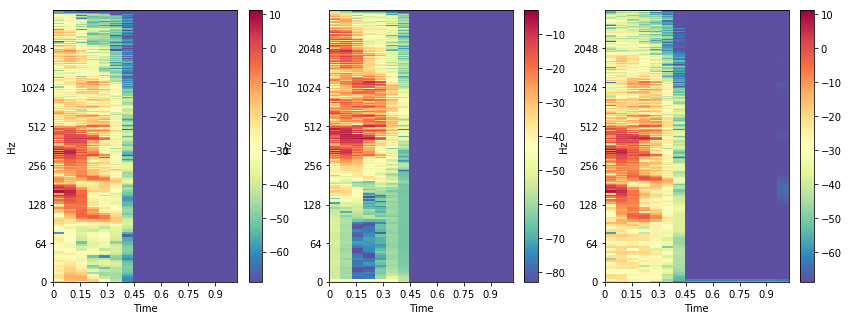

In [41]:
X=librosa.stft(xtest*max_test[p])
Xdec=librosa.stft(y*max_test[p])
Xfil=librosa.stft(xtest_fil*max_test_fil[p])
figure(figsize=(14, 5))
plt.subplot(1,3,1)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb.shape)
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
Xfildb = librosa.amplitude_to_db(abs(Xfil))
print(Xfildb.shape)
librosa.display.specshow(Xfildb, sr=sr, x_axis='time', y_axis='log',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
Xdecdb = librosa.amplitude_to_db(abs(Xdec))
print(Xdecdb.shape)
librosa.display.specshow(Xdecdb, sr=sr, x_axis='time', y_axis='log',cmap='Spectral_r')
colorbar()

In [42]:
error_spec=sklearn.metrics.mean_squared_error(Xdb,Xdecdb)
print(error_spec*1/Xdb.max())

3.715671373600998


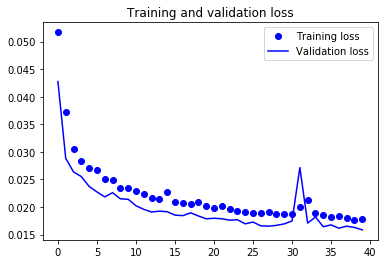

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

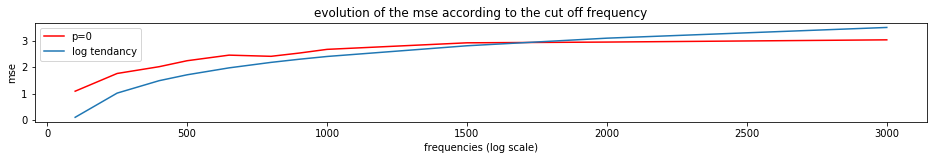

In [44]:
fc=[100,250,400,500,650,800,900,1000,1500,2000,3000]
mse0=[1.0935,1.7645,2.0208,2.2470,2.4586,2.4140,2.5361,2.6770,2.9249,2.9532,3.0375]

fig=plt.figure(figsize=(16, 4))
ax=fig.add_subplot(2,1,1)
plt.plot(fc,mse0,"r",label="p=0")
plt.plot(fc,np.log(fc)-4.5,label="log tendancy")
# ax.set_xscale('log')
plt.xlabel("frequencies (log scale)")
plt.ylabel('mse')
title("evolution of the mse according to the cut off frequency" )
plt.legend()
plt.show()

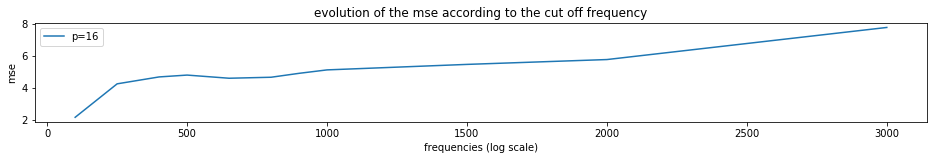

In [45]:
mse16=[2.1522,4.2412,4.6722,4.7873,4.5901,4.6523,4.8966,5.1111,5.4540,5.7564,7.7594]
fig=plt.figure(figsize=(16, 4))
ax=fig.add_subplot(2,1,1)

plt.plot(fc,mse16,label="p=16")
# ax.set_xscale('log')
plt.xlabel("frequencies (log scale)")
plt.ylabel('mse')
title("evolution of the mse according to the cut off frequency" )
plt.legend()
plt.show()